#Start


In [ ]:
pip install alpaca-trade-api pandas numpy scikit-learn matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.7/323.7 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.5/705.5 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 8.4 MB/s eta 0:00:00
  Attempting uninstall: msgpack
    Found existing installation: msgpack 1.1.0
    Uninstalling msgpack-1.1.0:
      Successfully uninstalled msgpack-1.1.0
  Attempting uninstall: websockets
    Found existing installation: websockets 14.1
    Uninstalling websockets-14.1:
      Successfully uninstalled websockets-14.1
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.2.3
    Uninstalling urllib3-2.2.3:
      Successfully uninstalled urllib3-2.2.3
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 6.0.2
    Uninstalling PyYAML-6.0.2:
      Success

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [ ]:
import alpaca_trade_api as tradeapi
import os
# Replace with your own API credentials
api_key = 'PKFF5MRCWCVMCA7PMJRG'
api_secret = 'YdOnIQMBEIa8u4FIIHLbhSvABAx4macI54hRLYiM'
BASE_URL = 'https://paper-api.alpaca.markets'  # Use paper trading base URL

# Initialize the API connection
api = tradeapi.REST(api_key, api_secret, BASE_URL, api_version='v2')
# Get account information
account = api.get_account()

# Print account details
print(f"Account status: {account.status}")
print(f"Equity: {account.equity}")
print(f"Buying power: {account.buying_power}")


Account status: ACTIVE
Equity: 100914.78
Buying power: 191904.36


#Data


In [ ]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
    # Install required packages if not already installed

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4011    0  4011    0     0  17941      0 --:--:-- --:--:-- --:--:-- 17986
100  517k  100  517k    0     0   803k      0 --:--:-- --:--:-- --:--:-- 5800k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3971    0  3971    0     0  13725      0 --:--:-- --:--:-- --:--:-- 13740
100  392k  100  392k    0     0   602k      0 --:--:-- --:--:-- --:--:--  602k


Cross-Validation R^2 Scores: [0.66825622 0.70891764 0.68359886 0.69634779 0.64014622]
Mean R^2 Score: 0.679453346803619
Best Parameters (UPO): GDX_weight          4.0
lookback           30.0
entry_threshold     1.0
Name: 325, dtype: float64


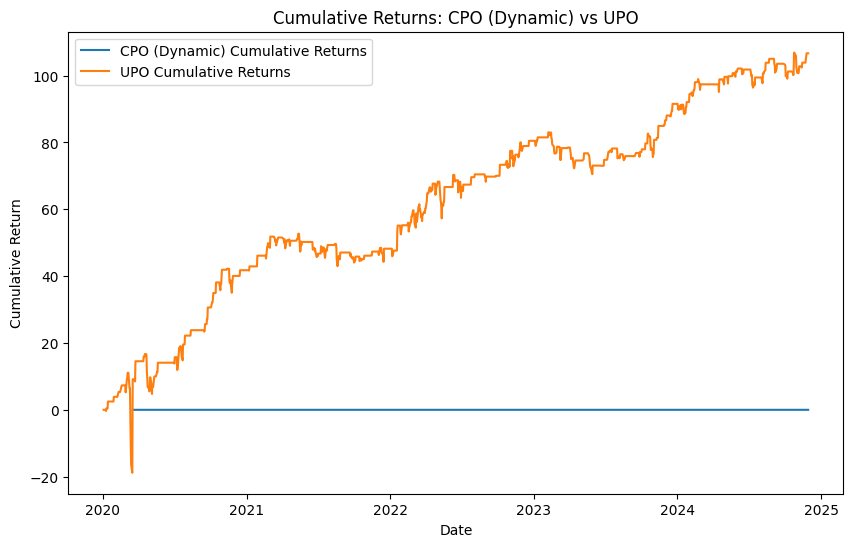

CPO (Dynamic) Performance: Final Cumulative Return = 0.0
UPO Performance: Final Cumulative Return = 106.66000000000005


In [ ]:
import alpaca_trade_api as tradeapi
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt


# Fetch historical data
def fetch_historical_data(symbol, start, end, timeframe='1Day'):
    data = api.get_bars(symbol, timeframe, start=start, end=end).df
    data.index = pd.to_datetime(data.index)
    return data

# Fetch data for GLD and GDX
start_date = "2020-01-01"
end_date = "2024-12-01"

gld_data = fetch_historical_data('GLD', start_date, end_date)
gdx_data = fetch_historical_data('GDX', start_date, end_date)

# Combine data into a single DataFrame
data = pd.DataFrame({
    'GLD': gld_data['close'],
    'GDX': gdx_data['close']
})

# Parameter grid
GDX_weights = [2, 2.5, 3, 3.5, 4]
entry_thresholds = [0.2, 0.3, 0.4, 0.5, 0.7, 1, 1.25, 1.5, 2, 2.5]
lookbacks = [30, 60, 90, 120, 180, 240, 360, 720]

def calculate_indicators(data, GDX_weight, lookback):
    """
    Calculate indicators like Spread, Spread_EMA, Spread_VAR, and Z_Score.
    """
    # Make an explicit copy to avoid SettingWithCopyWarning
    data = data.copy()

    # Ensure the Spread column is created
    data['Spread'] = data['GLD'] - GDX_weight * data['GDX']

    # Handle potential missing values (in case of rolling operations)
    if data['Spread'].isnull().all():
        raise ValueError("The 'Spread' column is empty after calculation. Check your data inputs.")

    # Ensure 'Spread_EMA' and 'Spread_VAR' are calculated
    data['Spread_EMA'] = data['Spread'].ewm(span=lookback).mean()
    data['Spread_VAR'] = data['Spread'].ewm(span=lookback).var()

    # Calculate Z-Score
    data['Z_Score'] = (data['Spread'] - data['Spread_EMA']) / np.sqrt(data['Spread_VAR'])

    return data

# Prepare dataset for model training
def prepare_dataset(data, GDX_weights, entry_thresholds, lookbacks):
    rows = []
    for GDX_weight in GDX_weights:
        for lookback in lookbacks:
            for entry_threshold in entry_thresholds:
                temp_data = calculate_indicators(data.copy(), GDX_weight, lookback)
                temp_data['Signal'] = 0
                temp_data.loc[temp_data['Z_Score'] > entry_threshold, 'Signal'] = -1  # Short
                temp_data.loc[temp_data['Z_Score'] < -entry_threshold, 'Signal'] = 1  # Long
                temp_data['Return'] = temp_data['Spread'].diff()
                temp_data['Strategy_Return'] = temp_data['Signal'].shift(1) * temp_data['Return']
                cumulative_return = temp_data['Strategy_Return'].cumsum().iloc[-1]
                rows.append({
                    'GDX_weight': GDX_weight,
                    'lookback': lookback,
                    'entry_threshold': entry_threshold,
                    'cumulative_return': cumulative_return
                })
    return pd.DataFrame(rows)

# Prepare dataset
feature_data = prepare_dataset(data, GDX_weights, entry_thresholds, lookbacks)

# Train regression model for CPO
X = feature_data[['GDX_weight', 'lookback', 'entry_threshold']]
y = feature_data['cumulative_return']

# Cross-validate the model
model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("Cross-Validation R^2 Scores:", cv_scores)
print("Mean R^2 Score:", np.mean(cv_scores))

# Perform Unconditional Parameter Optimization (UPO)
upo_best_row = feature_data.iloc[feature_data['cumulative_return'].idxmax()]
best_params_upo = upo_best_row[['GDX_weight', 'lookback', 'entry_threshold']]
print("Best Parameters (UPO):", best_params_upo)

# Apply UPO
upo_data = calculate_indicators(data.copy(), upo_best_row['GDX_weight'], upo_best_row['lookback'])
upo_data['Signal'] = 0
upo_data.loc[upo_data['Z_Score'] > upo_best_row['entry_threshold'], 'Signal'] = -1  # Short
upo_data.loc[upo_data['Z_Score'] < -upo_best_row['entry_threshold'], 'Signal'] = 1  # Long
upo_data['Return'] = upo_data['Spread'].diff()
upo_data['Strategy_Return'] = upo_data['Signal'].shift(1) * upo_data['Return']
upo_data['Cumulative_Return'] = upo_data['Strategy_Return'].cumsum()

# Conditional Parameter Optimization
def conditional_parameter_optimization_dynamic(data, model, rolling_window=50):
    """
    Dynamically predict best parameters for each rolling period using CPO.
    """
    # Add placeholder columns for dynamic parameters
    data['GDX_weight'] = 0.0
    data['lookback'] = 0
    data['entry_threshold'] = 0.0
    data['Signal'] = 0
    data['Spread'] = np.nan
    data['Spread_EMA'] = np.nan
    data['Spread_VAR'] = np.nan
    data['Z_Score'] = np.nan

    for i in range(rolling_window, len(data)):
        rolling_data = feature_data.iloc[:i]
        X_train = rolling_data[['GDX_weight', 'lookback', 'entry_threshold']]
        y_train = rolling_data['cumulative_return']

        # Fit the model on the rolling window
        model.fit(X_train, y_train)

        # Predict the best parameters for the next day
        predictions = model.predict(X_train)
        best_index = np.argmax(predictions)
        best_params = rolling_data.iloc[best_index][['GDX_weight', 'lookback', 'entry_threshold']]

        # Apply the best parameters to generate the signal
        current_data = calculate_indicators(data.iloc[i - 1:i], float(best_params['GDX_weight']), int(best_params['lookback']))
        z_score = current_data['Z_Score'].iloc[0]

        # Store the calculated values back into the main DataFrame
        data.loc[data.index[i], 'Spread'] = current_data['Spread'].iloc[0]
        data.loc[data.index[i], 'Spread_EMA'] = current_data['Spread_EMA'].iloc[0]
        data.loc[data.index[i], 'Spread_VAR'] = current_data['Spread_VAR'].iloc[0]
        data.loc[data.index[i], 'Z_Score'] = z_score

        # Determine the signal
        if z_score > float(best_params['entry_threshold']):
            data.loc[data.index[i], 'Signal'] = -1  # Short
        elif z_score < -float(best_params['entry_threshold']):
            data.loc[data.index[i], 'Signal'] = 1  # Long

        # Store the best parameters
        data.loc[data.index[i], 'GDX_weight'] = float(best_params['GDX_weight'])
        data.loc[data.index[i], 'lookback'] = int(best_params['lookback'])
        data.loc[data.index[i], 'entry_threshold'] = float(best_params['entry_threshold'])

    return data

# Apply dynamic CPO
cpo_data_dynamic = data.copy()
cpo_data_dynamic = conditional_parameter_optimization_dynamic(cpo_data_dynamic, model)

# Calculate strategy returns for CPO
cpo_data_dynamic['Return'] = cpo_data_dynamic['Spread'].diff()
cpo_data_dynamic['Strategy_Return'] = cpo_data_dynamic['Signal'].shift(1) * cpo_data_dynamic['Return']
cpo_data_dynamic['Cumulative_Return'] = cpo_data_dynamic['Strategy_Return'].cumsum()

# Plot CPO vs UPO
plt.figure(figsize=(10, 6))
plt.plot(cpo_data_dynamic['Cumulative_Return'], label='CPO (Dynamic) Cumulative Returns')
plt.plot(upo_data['Cumulative_Return'], label='UPO Cumulative Returns')
plt.title('Cumulative Returns: CPO (Dynamic) vs UPO')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

# Performance Summary
print("CPO (Dynamic) Performance: Final Cumulative Return =", cpo_data_dynamic['Cumulative_Return'].iloc[-1])
print("UPO Performance: Final Cumulative Return =", upo_data['Cumulative_Return'].iloc[-1])


In [ ]:
import alpaca_trade_api as tradeapi
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Fetch historical data
def fetch_historical_data(symbol, start, end, timeframe='1Day'):
    logging.info(f"Fetching data for {symbol} from {start} to {end}")
    data = api.get_bars(symbol, timeframe, start=start, end=end).df
    data.index = pd.to_datetime(data.index)
    # Sort and ensure uniqueness
    data = data.sort_index().drop_duplicates()
    return data

start_date = "2015-01-01"  # Extended date for longer historical data
end_date = "2024-12-01"

api_key = 'PKFF5MRCWCVMCA7PMJRG'
api_secret = 'YdOnIQMBEIa8u4FIIHLbhSvABAx4macI54hRLYiM'
BASE_URL = 'https://paper-api.alpaca.markets'  # Use paper trading base URL

# Initialize the API connection
api = tradeapi.REST(api_key, api_secret, BASE_URL, api_version='v2')

gld_data = fetch_historical_data('GLD', start_date, end_date)
gdx_data = fetch_historical_data('GDX', start_date, end_date)

# Align data
common_index = gld_data.index.intersection(gdx_data.index)
gld_data = gld_data.loc[common_index]
gdx_data = gdx_data.loc[common_index]

# Combine data into a single DataFrame
data = pd.DataFrame({
    'GLD': gld_data['close'],
    'GDX': gdx_data['close']
})
data = data.dropna()
logging.info(f"Data head after fetching and aligning:\n{data.head()}")

# Parameter grid
GDX_weights = [2, 2.5, 3, 3.5, 4]
entry_thresholds = [0.2, 0.3, 0.4, 0.5, 0.7, 1, 1.25, 1.5, 2, 2.5]
lookbacks = [30, 60, 90, 120, 180]  # Reduced to avoid insufficient data issues

def calculate_indicators(data, GDX_weight, lookback):
    try:
        data = data.copy()
        data['Spread'] = data['GLD'] - GDX_weight * data['GDX']
        data['Spread_EMA'] = data['Spread'].ewm(span=lookback, adjust=False).mean()
        data['Spread_VAR'] = data['Spread'].ewm(span=lookback, adjust=False).var()
        data['Z_Score'] = (data['Spread'] - data['Spread_EMA']) / np.sqrt(data['Spread_VAR'])

        # Debug logs
        logging.info(f"Spread Head:\n{data['Spread'].head()}")
        logging.info(f"Spread EMA Head:\n{data['Spread_EMA'].head()}")
        logging.info(f"Spread VAR Head:\n{data['Spread_VAR'].head()}")
        logging.info(f"Z-Score Head:\n{data['Z_Score'].head()}")

        return data

    except Exception as e:
        logging.error(f"Error in calculate_indicators: {e}")
        return pd.DataFrame()


def prepare_dataset(full_data, GDX_weights, entry_thresholds, lookbacks):
    """
    Prepare dataset by evaluating all parameter combos on the given historical dataset.
    Assumes full_data is sufficient length to calculate indicators.
    """
    rows = []
    for GDX_weight in GDX_weights:
        for lookback in lookbacks:
            # Adjust lookback dynamically
            if len(full_data) < lookback:
                adjusted_lookback = max(30, len(full_data) - 1)
                logging.warning(f"Adjusting lookback from {lookback} to {adjusted_lookback}")
            else:
                adjusted_lookback = lookback

            temp_data = calculate_indicators(full_data, GDX_weight, adjusted_lookback)
            for entry_threshold in entry_thresholds:
                logging.info(f"Calculating for GDX_weight={GDX_weight}, lookback={adjusted_lookback}, threshold={entry_threshold}")
                temp_temp_data = temp_data.copy()
                temp_temp_data['Signal'] = 0
                temp_temp_data.loc[temp_temp_data['Z_Score'] > entry_threshold, 'Signal'] = -1  # Short
                temp_temp_data.loc[temp_temp_data['Z_Score'] < -entry_threshold, 'Signal'] = 1  # Long
                temp_temp_data['Return'] = temp_temp_data['Spread'].diff()
                temp_temp_data['Strategy_Return'] = temp_temp_data['Signal'].shift(1) * temp_temp_data['Return']
                cumulative_return = temp_temp_data['Strategy_Return'].cumsum().iloc[-1]
                rows.append({
                    'GDX_weight': GDX_weight,
                    'lookback': adjusted_lookback,
                    'entry_threshold': entry_threshold,
                    'cumulative_return': cumulative_return
                })
    logging.info(f"Generated {len(rows)} rows in feature dataset")
    return pd.DataFrame(rows)

# Prepare full feature dataset (UPO scenario)
feature_data = prepare_dataset(data, GDX_weights, entry_thresholds, lookbacks)
logging.info(f"Feature data head:\n{feature_data.head()}")

# Train regression model for UPO
X = feature_data[['GDX_weight', 'lookback', 'entry_threshold']]
y = feature_data['cumulative_return']
model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
logging.info(f"Cross-Validation R^2 Scores: {cv_scores}")
logging.info(f"Mean R^2 Score: {np.mean(cv_scores)}")

# Perform Unconditional Parameter Optimization (UPO)
upo_best_row = feature_data.iloc[feature_data['cumulative_return'].idxmax()]
best_params_upo = upo_best_row[['GDX_weight', 'lookback', 'entry_threshold']]
logging.info(f"Best Parameters (UPO): {best_params_upo}")

# Ensure clean input data for UPO
upo_data = data.copy().fillna(0)

# Perform Unconditional Parameter Optimization (UPO)
upo_data = calculate_indicators(upo_data, upo_best_row['GDX_weight'], upo_best_row['lookback'])
upo_data['Signal'] = 0
upo_data.loc[upo_data['Z_Score'] > upo_best_row['entry_threshold'], 'Signal'] = -1  # Short
upo_data.loc[upo_data['Z_Score'] < -upo_best_row['entry_threshold'], 'Signal'] = 1  # Long
upo_data['Return'] = upo_data['Spread'].diff()
upo_data['Strategy_Return'] = upo_data['Signal'].shift(1) * upo_data['Return']
upo_data['Cumulative_Return'] = upo_data['Strategy_Return'].cumsum()


In [ ]:
data

,GLD,GDX
timestamp,,
2016-01-04 05:00:00+00:00,102.89,14.11
2016-01-05 05:00:00+00:00,103.18,14.01
2016-01-06 05:00:00+00:00,104.67,14.25
2016-01-07 05:00:00+00:00,106.15,14.88
2016-01-08 05:00:00+00:00,105.68,14.50
...,...,...
2024-11-22 05:00:00+00:00,249.84,38.28
2024-11-25 05:00:00+00:00,242.48,37.14
2024-11-26 05:00:00+00:00,242.95,37.29


#Cointegration Test

In [1]:
from statsmodels.tsa.stattools import coint
import yfinance as yf

# Define tickers
tickers = ['GLD', 'GDX']

# Fetch price data
data = yf.download(tickers, start="2022-01-01", end="2023-12-01")['Adj Close']

# Perform cointegration test
score, p_value, _ = coint(data['GLD'], data['GDX'])

print(f"Cointegration Test p-value: {p_value:.4f}")
if p_value < 0.05:
    print("The pair is cointegrated (p < 0.05)")
else:
    print("The pair is not cointegrated (p >= 0.05)")


[*********************100%***********************]  2 of 2 completed

Cointegration Test p-value: 0.9251
The pair is not cointegrated (p >= 0.05)


# Yeni Bölüm

In [ ]:
import alpaca_trade_api as tradeapi
import os
# Replace with your own API credentials
api_key = 'PKFF5MRCWCVMCA7PMJRG'
api_secret = 'YdOnIQMBEIa8u4FIIHLbhSvABAx4macI54hRLYiM'
BASE_URL = 'https://paper-api.alpaca.markets'  # Use paper trading base URL

# Initialize the API connection
api = tradeapi.REST(api_key, api_secret, BASE_URL, api_version='v2')
# Get account information
account = api.get_account()

# Print account details
print(f"Account status: {account.status}")
print(f"Equity: {account.equity}")
print(f"Buying power: {account.buying_power}")


Account status: ACTIVE
Equity: 100914.78
Buying power: 191904.36


In [ ]:
# Fetch historical data
def fetch_historical_data(symbol, start, end, timeframe='1Day'):
    data = api.get_bars(symbol, timeframe, start=start, end=end).df
    data.index = pd.to_datetime(data.index)
    return data

# Fetch data for GLD and GDX
start_date = "2020-01-01"
end_date = "2024-12-01"

gld_data = fetch_historical_data('GLD', start_date, end_date)
gdx_data = fetch_historical_data('GDX', start_date, end_date)

# Combine data into a single DataFrame
data = pd.DataFrame({
    'GLD': gld_data['close'],
    'GDX': gdx_data['close']
})

# Parameter grid
GDX_weights = [2, 2.5, 3, 3.5, 4]
entry_thresholds = [0.2, 0.3, 0.4, 0.5, 0.7, 1, 1.25, 1.5, 2, 2.5]
lookbacks = [30, 60, 90, 120, 180, 240, 360, 720]

In [ ]:
data

,GLD,GDX
timestamp,,
2020-01-02 05:00:00+00:00,143.95,29.35
2020-01-03 05:00:00+00:00,145.86,29.17
2020-01-06 05:00:00+00:00,147.39,29.22
2020-01-07 05:00:00+00:00,147.97,29.50
2020-01-08 05:00:00+00:00,146.86,28.34
...,...,...
2024-11-22 05:00:00+00:00,249.84,38.28
2024-11-25 05:00:00+00:00,242.48,37.14
2024-11-26 05:00:00+00:00,242.95,37.29


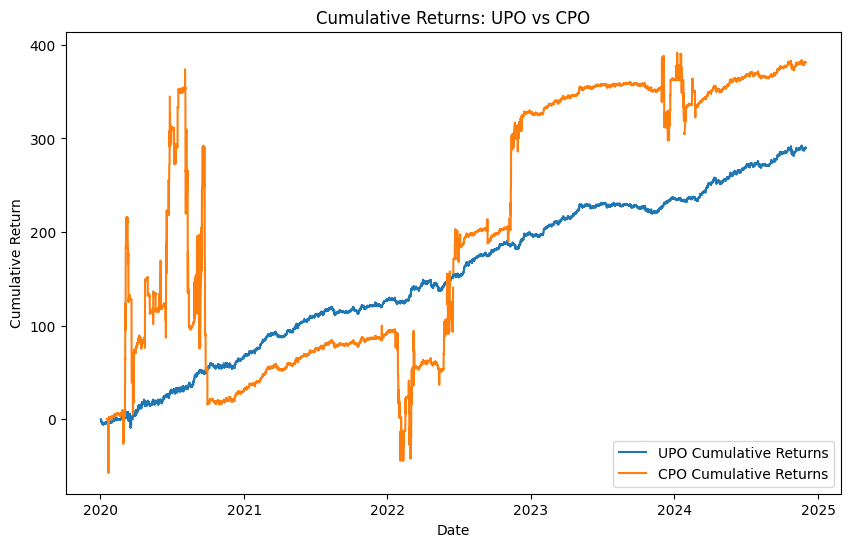

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
# Fetch historical data
def fetch_historical_data(symbol, start, end, timeframe='1Hour'):
    data = api.get_bars(symbol, timeframe, start=start, end=end).df
    data.index = pd.to_datetime(data.index)
    return data

# Fetch data for GLD and GDX
start_date = "2020-01-01"
end_date = "2024-12-01"

gld_data = fetch_historical_data('GLD', start_date, end_date)
gdx_data = fetch_historical_data('GDX', start_date, end_date)

# Combine data into a single DataFrame
data = pd.DataFrame({
    'GLD': gld_data['close'],
    'GDX': gdx_data['close']
})

# Parameter grid
GDX_weights = [2, 2.5, 3, 3.5, 4]
entry_thresholds = [0.2, 0.3, 0.4, 0.5, 0.7, 1, 1.25, 1.5, 2, 2.5]
lookbacks = [30, 60, 90, 120, 180, 240, 360, 720]

def calculate_indicators(df, GDX_weight, lookback):
    """
    Calculate indicators like Spread, Spread_EMA, Spread_VAR, and Z_Score.
    Requires df to have length > lookback for stable calculations.
    """
    df = df.copy()
    df['Spread'] = df['GLD'] - GDX_weight * df['GDX']
    df['Spread_EMA'] = df['Spread'].ewm(span=lookback).mean()
    df['Spread_VAR'] = df['Spread'].ewm(span=lookback).var()
    df['Z_Score'] = (df['Spread'] - df['Spread_EMA']) / np.sqrt(df['Spread_VAR'])
    return df

def prepare_dataset(df, GDX_weights, entry_thresholds, lookbacks):
    """
    Prepare a feature dataset using the entire available df.
    For each parameter combo, compute cumulative returns over the whole period.
    """
    rows = []
    for GDX_weight in GDX_weights:
        for lookback in lookbacks:
            # Ensure we have enough data to compute indicators
            if len(df) <= lookback:
                continue
            temp_data = calculate_indicators(df, GDX_weight, lookback)
            for entry_threshold in entry_thresholds:
                temp_temp_data = temp_data.copy()
                temp_temp_data['Signal'] = 0
                temp_temp_data.loc[temp_temp_data['Z_Score'] > entry_threshold, 'Signal'] = -1  # Short
                temp_temp_data.loc[temp_temp_data['Z_Score'] < -entry_threshold, 'Signal'] = 1  # Long
                temp_temp_data['Return'] = temp_temp_data['Spread'].diff()
                temp_temp_data['Strategy_Return'] = temp_temp_data['Signal'].shift(1) * temp_temp_data['Return']
                cumulative_return = temp_temp_data['Strategy_Return'].cumsum().iloc[-1]
                rows.append({
                    'GDX_weight': GDX_weight,
                    'lookback': lookback,
                    'entry_threshold': entry_threshold,
                    'cumulative_return': cumulative_return
                })
    return pd.DataFrame(rows)

# Prepare full feature data for UPO (from entire dataset)
feature_data = prepare_dataset(data, GDX_weights, entry_thresholds, lookbacks)
logging.info("Feature data prepared.")
logging.info(f"Feature data head:\n{feature_data.head()}")

def perform_upo(data, feature_data):
    """
    Perform Unconditional Parameter Optimization (UPO) by selecting the best parameters in-sample.
    """
    upo_best_row = feature_data.iloc[feature_data['cumulative_return'].idxmax()]
    best_params = upo_best_row[['GDX_weight', 'lookback', 'entry_threshold']]
    logging.info(f"Best Parameters (UPO): {best_params}")

    data_upo = calculate_indicators(data.copy(), best_params['GDX_weight'], best_params['lookback'])
    data_upo['Signal'] = 0
    data_upo.loc[data_upo['Z_Score'] > best_params['entry_threshold'], 'Signal'] = -1
    data_upo.loc[data_upo['Z_Score'] < -best_params['entry_threshold'], 'Signal'] = 1
    data_upo['Return'] = data_upo['Spread'].diff()
    data_upo['Strategy_Return'] = data_upo['Signal'].shift(1) * data_upo['Return']
    data_upo['Cumulative_Return'] = data_upo['Strategy_Return'].cumsum()
    return data_upo, best_params

def perform_cpo(data, GDX_weights, entry_thresholds, lookbacks, rolling_window=180):
    """
    Perform Conditional Parameter Optimization (CPO) with a walk-forward approach.
    For each day i (after rolling_window), we:
      - Use all data up to i-1 to create rolling_feature_data.
      - Train model and pick best parameters based on historical predictions.
      - Apply these parameters to day i.
    """
    model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)

    data = data.copy()
    data['Signal'] = 0
    data['Spread'] = np.nan
    data['Spread_EMA'] = np.nan
    data['Spread_VAR'] = np.nan
    data['Z_Score'] = np.nan

    logging.info("Starting CPO...")

    # Minimum lookback required for stable indicators
    min_lookback = min(lookbacks)

    for i in range(rolling_window, len(data)):
        # Historical data (up to yesterday)
        historical_data = data.iloc[:i].dropna(subset=['GLD', 'GDX'])
        if len(historical_data) < min_lookback:
            # Not enough data to compute indicators meaningfully
            continue

        # Prepare rolling feature dataset from historical data only
        rolling_feature_data = prepare_dataset(historical_data, GDX_weights, entry_thresholds, lookbacks)
        if rolling_feature_data.empty:
            continue

        X_train = rolling_feature_data[['GDX_weight', 'lookback', 'entry_threshold']]
        y_train = rolling_feature_data['cumulative_return']

        # Train the model on historical (in-sample) data
        model.fit(X_train, y_train)

        # Predict returns for all parameter combos in the historical set
        predictions = model.predict(X_train)
        best_index = np.argmax(predictions)
        best_params = rolling_feature_data.iloc[best_index][['GDX_weight', 'lookback', 'entry_threshold']]

        # Apply best parameters to current day i
        # Need at least 'lookback' days of data to compute indicators
        lb = int(best_params['lookback'])
        if i < lb:
            continue

        # Compute indicators up to day i (including day i)
        window_data = data.iloc[:i+1]  # up to current index
        indicators_data = calculate_indicators(window_data.copy(), best_params['GDX_weight'], lb)
        current_row = indicators_data.iloc[-1]

        # Update data with the computed indicators
        data.loc[data.index[i], 'Spread'] = current_row['Spread']
        data.loc[data.index[i], 'Spread_EMA'] = current_row['Spread_EMA']
        data.loc[data.index[i], 'Spread_VAR'] = current_row['Spread_VAR']
        data.loc[data.index[i], 'Z_Score'] = current_row['Z_Score']

        # Determine signal based on Z_Score
        thr = float(best_params['entry_threshold'])
        if current_row['Z_Score'] > thr:
            data.loc[data.index[i], 'Signal'] = -1  # Short
        elif current_row['Z_Score'] < -thr:
            data.loc[data.index[i], 'Signal'] = 1   # Long

        logging.info(
            f"Date: {data.index[i]}, Best Params: {best_params.to_dict()}, "
            f"Z-Score: {current_row['Z_Score']:.2f}, Signal: {data.loc[data.index[i], 'Signal']}"
        )

    # Calculate returns and cumulative returns
    data['Return'] = data['Spread'].diff()
    data['Strategy_Return'] = data['Signal'].shift(1) * data['Return']
    data['Cumulative_Return'] = data['Strategy_Return'].cumsum()

    logging.info("CPO completed.")
    return data

# Perform UPO
upo_data, upo_params = perform_upo(data.copy(), feature_data)

# Perform CPO (dynamic)
cpo_data = perform_cpo(data.copy(), GDX_weights, entry_thresholds, lookbacks, rolling_window=180)

# Plot cumulative returns for both UPO and CPO
plt.figure(figsize=(10, 6))
plt.plot(upo_data['Cumulative_Return'], label='UPO Cumulative Returns')
plt.plot(cpo_data['Cumulative_Return'], label='CPO Cumulative Returns')
plt.title('Cumulative Returns: UPO vs CPO')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

# Performance Summary
logging.info(f"UPO Performance: Final Cumulative Return = {upo_data['Cumulative_Return'].iloc[-1]:.2f}")
if cpo_data['Cumulative_Return'].notna().any():
    logging.info(f"CPO Performance: Final Cumulative Return = {cpo_data['Cumulative_Return'].iloc[-1]:.2f}")
else:
    logging.info("CPO produced no valid signals or returns.")


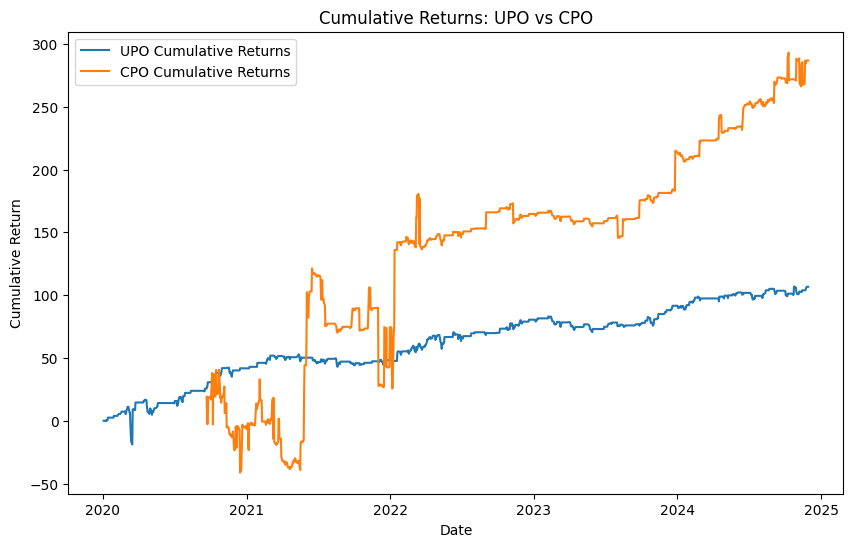

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import logging
from joblib import Parallel, delayed
import pickle

# Set up logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Fetch historical data
def fetch_historical_data(symbol, start, end, timeframe='1Day'):
    data = api.get_bars(symbol, timeframe, start=start, end=end).df
    data.index = pd.to_datetime(data.index)
    return data

# Indicator calculations
def calculate_indicators(df, GDX_weight, lookback):
    lookback = int(lookback)
    if lookback <= 0:
        raise ValueError(f"Invalid lookback period: {lookback}. Must be a positive integer.")
    df = df.copy()
    df['Spread'] = df['GLD'] - GDX_weight * df['GDX']
    df['Spread_EMA'] = df['Spread'].ewm(span=lookback).mean()
    df['Spread_VAR'] = df['Spread'].ewm(span=lookback).var()
    df['Z_Score'] = (df['Spread'] - df['Spread_EMA']) / np.sqrt(df['Spread_VAR'])
    df['Bollinger_Upper'] = df['Spread_EMA'] + 2 * np.sqrt(df['Spread_VAR'])
    df['Bollinger_Lower'] = df['Spread_EMA'] - 2 * np.sqrt(df['Spread_VAR'])
    df['Money_Flow'] = (df['GLD'] * df['GDX']).ewm(span=lookback).mean()
    df['Force_Index'] = (df['GLD'].diff() * df['GDX']).ewm(span=lookback).mean()
    df['Donchian_High'] = df['Spread'].rolling(window=lookback).max()
    df['Donchian_Low'] = df['Spread'].rolling(window=lookback).min()
    df['ATR'] = (df['GLD'].diff().abs() + df['GDX'].diff().abs()).ewm(span=lookback).mean()
    df['Awesome_Osc'] = (df['GLD'] - df['GDX']).ewm(span=5).mean() - (df['GLD'] - df['GDX']).ewm(span=34).mean()
    df['ADX'] = 100 * (df['GLD'].diff().abs() / (df['GLD'] + df['GDX']).ewm(span=lookback).mean())
    return df

# Feature preparation
def prepare_dataset(df, GDX_weights, entry_thresholds, lookbacks):
    """
    Prepare a feature dataset using the entire available df.
    For each parameter combo, compute cumulative returns over the whole period.
    """
    rows = []
    for GDX_weight in GDX_weights:
        for lookback in lookbacks:
            # Ensure we have enough data to compute indicators
            if len(df) <= lookback:
                continue
            temp_data = calculate_indicators(df, GDX_weight, lookback)
            for entry_threshold in entry_thresholds:
                temp_temp_data = temp_data.copy()
                temp_temp_data['Signal'] = 0
                temp_temp_data.loc[temp_temp_data['Z_Score'] > entry_threshold, 'Signal'] = -1  # Short
                temp_temp_data.loc[temp_temp_data['Z_Score'] < -entry_threshold, 'Signal'] = 1  # Long
                temp_temp_data['Return'] = temp_temp_data['Spread'].diff()
                temp_temp_data['Strategy_Return'] = temp_temp_data['Signal'].shift(1) * temp_temp_data['Return']
                cumulative_return = temp_temp_data['Strategy_Return'].cumsum().iloc[-1]
                rows.append({
                    'GDX_weight': GDX_weight,
                    'lookback': lookback,
                    'entry_threshold': entry_threshold,
                    'cumulative_return': cumulative_return
                })
    return pd.DataFrame(rows)
# Perform Unconditional Parameter Optimization (UPO)
def perform_upo(data, feature_data):
    upo_best_row = feature_data.iloc[feature_data['cumulative_return'].idxmax()]
    best_params = upo_best_row[['GDX_weight', 'lookback', 'entry_threshold']]
    logging.info(f"Best Parameters (UPO): {best_params}")

    data_upo = calculate_indicators(data.copy(), best_params['GDX_weight'], best_params['lookback'])
    data_upo['Signal'] = 0
    data_upo.loc[data_upo['Z_Score'] > best_params['entry_threshold'], 'Signal'] = -1
    data_upo.loc[data_upo['Z_Score'] < -best_params['entry_threshold'], 'Signal'] = 1
    data_upo['Return'] = data_upo['Spread'].diff()
    data_upo['Strategy_Return'] = data_upo['Signal'].shift(1) * data_upo['Return']
    data_upo['Cumulative_Return'] = data_upo['Strategy_Return'].cumsum()
    return data_upo, best_params

def perform_cpo(data, GDX_weights, entry_thresholds, lookbacks, rolling_window=180):
    model = RandomForestRegressor(n_estimators=10, max_depth=3, n_jobs=-1, random_state=42)
    data = data.copy()
    data['Signal'] = 0
    data['Spread'] = np.nan
    data['Spread_EMA'] = np.nan
    data['Spread_VAR'] = np.nan
    data['Z_Score'] = np.nan
    logging.info("Starting CPO...")

    min_lookback = min(lookbacks)

    for i in range(rolling_window, len(data)):
        historical_data = data.iloc[:i].dropna(subset=['GLD', 'GDX'])
        if len(historical_data) < min_lookback:
            continue

        rolling_feature_data = prepare_dataset(historical_data, GDX_weights, entry_thresholds, lookbacks)
        if rolling_feature_data.empty:
            continue

        X_train = rolling_feature_data[['GDX_weight', 'lookback', 'entry_threshold']]
        y_train = rolling_feature_data['cumulative_return']
        model.fit(X_train, y_train)

        predictions = model.predict(X_train)
        best_index = np.argmax(predictions)
        best_params = rolling_feature_data.iloc[best_index][['GDX_weight', 'lookback', 'entry_threshold']]

        lb = int(best_params['lookback'])
        if i < lb:
            continue

        window_data = data.iloc[:i+1]
        indicators_data = calculate_indicators(window_data.copy(), best_params['GDX_weight'], lb)
        current_row = indicators_data.iloc[-1]

        data.loc[data.index[i], 'Spread'] = current_row['Spread']
        data.loc[data.index[i], 'Spread_EMA'] = current_row['Spread_EMA']
        data.loc[data.index[i], 'Spread_VAR'] = current_row['Spread_VAR']
        data.loc[data.index[i], 'Z_Score'] = current_row['Z_Score']

        thr = float(best_params['entry_threshold'])
        if current_row['Z_Score'] > thr:
            data.loc[data.index[i], 'Signal'] = -1
        elif current_row['Z_Score'] < -thr:
            data.loc[data.index[i], 'Signal'] = 1

        logging.info(
            f"Date: {data.index[i]}, Best Params: {best_params.to_dict()}, "
            f"Z-Score: {current_row['Z_Score']:.2f}, Signal: {data.loc[data.index[i], 'Signal']}"
        )

    data['Return'] = data['Spread'].diff()
    data['Strategy_Return'] = data['Signal'].shift(1) * data['Return']
    data['Cumulative_Return'] = data['Strategy_Return'].cumsum()
    logging.info("CPO completed.")
    return data, model  # Return the trained model as well

# Save the UPO and CPO results
def save_results(upo_data, cpo_data, upo_params, feature_data, model, save_path="./results/"):
    import os
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # Save UPO and CPO data
    upo_data.to_csv(os.path.join(save_path, "upo_data.csv"), index=True)
    cpo_data.to_csv(os.path.join(save_path, "cpo_data.csv"), index=True)

    # Save feature data
    feature_data.to_csv(os.path.join(save_path, "feature_data.csv"), index=False)

    # Save best UPO parameters
    with open(os.path.join(save_path, "upo_params.txt"), "w") as f:
        f.write("Best UPO Parameters:\n")
        f.write(str(upo_params))

    # Save statistics (summary of cumulative returns)
    with open(os.path.join(save_path, "performance_statistics.txt"), "w") as f:
        upo_return = upo_data['Cumulative_Return'].iloc[-1]
        cpo_return = cpo_data['Cumulative_Return'].iloc[-1] if cpo_data['Cumulative_Return'].notna().any() else 0.0
        f.write(f"UPO Performance: Final Cumulative Return = {upo_return:.2f}\n")
        f.write(f"CPO Performance: Final Cumulative Return = {cpo_return:.2f}\n")

    # Save trained model (Random Forest Regressor)
    with open(os.path.join(save_path, "random_forest_model.pkl"), "wb") as f:
        pickle.dump(model, f)

    logging.info(f"Results saved in folder: {save_path}")

# Main workflow
start_date = "2020-01-01"
end_date = "2024-12-01"
gld_data = fetch_historical_data('GLD', start_date, end_date)
gdx_data = fetch_historical_data('GDX', start_date, end_date)

data = pd.DataFrame({
    'GLD': gld_data['close'],
    'GDX': gdx_data['close']
})

GDX_weights = [2, 2.5, 3, 3.5, 4]
entry_thresholds = [0.2, 0.3, 0.4, 0.5, 0.7, 1, 1.25, 1.5, 2, 2.5]
lookbacks = [30, 60, 90, 120, 180, 240, 360, 720]

feature_data = prepare_dataset(data, GDX_weights, entry_thresholds, lookbacks)
logging.info("Feature data prepared.")

# Perform UPO
upo_data, upo_params = perform_upo(data.copy(), feature_data)

# Perform CPO (dynamic)
cpo_data, model = perform_cpo(data.copy(), GDX_weights, entry_thresholds, lookbacks, rolling_window=180)

# Save Results
save_results(upo_data, cpo_data, upo_params, feature_data, model)

plt.figure(figsize=(10, 6))
plt.plot(upo_data['Cumulative_Return'], label='UPO Cumulative Returns')
plt.plot(cpo_data['Cumulative_Return'], label='CPO Cumulative Returns')
plt.title('Cumulative Returns: UPO vs CPO')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

logging.info(f"UPO Performance: Final Cumulative Return = {upo_data['Cumulative_Return'].iloc[-1]:.2f}")
if cpo_data['Cumulative_Return'].notna().any():
    logging.info(f"CPO Performance: Final Cumulative Return = {cpo_data['Cumulative_Return'].iloc[-1]:.2f}")
else:
    logging.info("CPO produced no valid signals or returns.")


""


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import logging
from joblib import Parallel, delayed
import pickle

# Set up logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Fetch historical data
def fetch_historical_data(symbol, start, end, timeframe='4Hour'):
    data = api.get_bars(symbol, timeframe, start=start, end=end).df
    data.index = pd.to_datetime(data.index)
    return data

def calculate_indicators(df, GDX_weight, lookback):
    lookback = int(lookback)
    if lookback <= 0:
        raise ValueError(f"Invalid lookback period: {lookback}. Must be a positive integer.")

    df = df.copy()
    df['Spread'] = df['GLD'] - GDX_weight * df['GDX']
    df['Spread_EMA'] = df['Spread'].ewm(span=lookback).mean()
    df['Spread_VAR'] = df['Spread'].ewm(span=lookback).var()
    df['Z_Score'] = (df['Spread'] - df['Spread_EMA']) / np.sqrt(df['Spread_VAR'])

    # Additional indicators
    df['Bollinger_Upper'] = df['Spread_EMA'] + 2 * np.sqrt(df['Spread_VAR'])
    df['Bollinger_Lower'] = df['Spread_EMA'] - 2 * np.sqrt(df['Spread_VAR'])
    df['Money_Flow'] = (df['GLD'] * df['GDX']).ewm(span=lookback).mean()
    df['Force_Index'] = (df['GLD'].diff() * df['GDX']).ewm(span=lookback).mean()
    df['Donchian_High'] = df['Spread'].rolling(window=lookback).max()
    df['Donchian_Low'] = df['Spread'].rolling(window=lookback).min()
    df['ATR'] = (df['GLD'].diff().abs() + df['GDX'].diff().abs()).ewm(span=lookback).mean()
    df['Awesome_Osc'] = (df['GLD'] - df['GDX']).ewm(span=5).mean() - (df['GLD'] - df['GDX']).ewm(span=34).mean()
    df['ADX'] = 100 * (df['GLD'].diff().abs() / (df['GLD'] + df['GDX']).ewm(span=lookback).mean())
    return df

def prepare_dataset(df, GDX_weights, entry_thresholds, lookbacks):
    """
    Prepare a feature dataset:
    Each row corresponds to a specific parameter combination.
    We compute the strategy returns over the entire df and take the final cumulative_return.
    We also record the final-day indicators as features (Z_Score, ATR, Awesome_Osc, etc.)
    """
    rows = []
    for GDX_weight in GDX_weights:
        for lookback in lookbacks:
            if len(df) <= lookback:
                continue
            temp_data = calculate_indicators(df, GDX_weight, lookback)
            for entry_threshold in entry_thresholds:
                temp_temp_data = temp_data.copy()
                temp_temp_data['Signal'] = 0
                temp_temp_data.loc[temp_temp_data['Z_Score'] > entry_threshold, 'Signal'] = -1  # Short
                temp_temp_data.loc[temp_temp_data['Z_Score'] < -entry_threshold, 'Signal'] = 1  # Long
                temp_temp_data['Return'] = temp_temp_data['Spread'].diff()
                temp_temp_data['Strategy_Return'] = temp_temp_data['Signal'].shift(1) * temp_temp_data['Return']
                cumulative_return = temp_temp_data['Strategy_Return'].cumsum().iloc[-1]

                # Extract final-day indicators as features
                final_row = temp_temp_data.iloc[-1]
                rows.append({
                    'GDX_weight': GDX_weight,
                    'lookback': lookback,
                    'entry_threshold': entry_threshold,
                    'cumulative_return': cumulative_return,
                    'final_Z_Score': final_row['Z_Score'],
                    'final_ATR': final_row['ATR'],
                    'final_Force_Index': final_row['Force_Index'],
                    'final_Awesome_Osc': final_row['Awesome_Osc'],
                    'final_Bollinger_Upper': final_row['Bollinger_Upper'],
                    'final_Bollinger_Lower': final_row['Bollinger_Lower'],
                    'final_ADX': final_row['ADX']
                })
    return pd.DataFrame(rows)

def perform_upo(data, feature_data):
    """
    Perform Unconditional Parameter Optimization (UPO).
    Selects the best parameters based on maximum cumulative_return.
    """
    upo_best_row = feature_data.iloc[feature_data['cumulative_return'].idxmax()]
    best_params = upo_best_row[['GDX_weight', 'lookback', 'entry_threshold']]
    logging.info(f"Best Parameters (UPO): {best_params}")

    data_upo = calculate_indicators(data.copy(), best_params['GDX_weight'], best_params['lookback'])
    data_upo['Signal'] = 0
    data_upo.loc[data_upo['Z_Score'] > best_params['entry_threshold'], 'Signal'] = -1
    data_upo.loc[data_upo['Z_Score'] < -best_params['entry_threshold'], 'Signal'] = 1

    data_upo['Return'] = data_upo['Spread'].diff()
    data_upo['Strategy_Return'] = data_upo['Signal'].shift(1) * data_upo['Return']
    data_upo['Cumulative_Return'] = data_upo['Strategy_Return'].cumsum()

    logging.info("UPO completed.")
    return data_upo, best_params


def perform_cpo(data, GDX_weights, entry_thresholds, lookbacks, rolling_window=180):
    """
    Perform Conditional Parameter Optimization (CPO) with a walk-forward approach.

    For each day i > rolling_window:
      - Use all data up to i-1 to create rolling_feature_data (param combos + final-day indicators from historical period).
      - Train a model on this historical feature data.
      - Pick the best parameters for day i based on the model's predictions.
      - Compute indicators for day i using these parameters and set the signal.
    """
    model = RandomForestRegressor(n_estimators=22, max_depth=3, n_jobs=-1, random_state=42)
    data = data.copy()
    data['Signal'] = 0
    data['Spread'] = np.nan
    data['Z_Score'] = np.nan

    logging.info("Starting CPO...")

    min_lookback = min(lookbacks)

    for i in range(rolling_window, len(data)):
        historical_data = data.iloc[:i].dropna(subset=['GLD', 'GDX'])
        if len(historical_data) < min_lookback:
            continue

        # Generate feature data from historical portion only
        rolling_feature_data = prepare_dataset(historical_data, GDX_weights, entry_thresholds, lookbacks)
        if rolling_feature_data.empty:
            continue

        # Training features
        X_train = rolling_feature_data[['GDX_weight', 'lookback', 'entry_threshold',
                                        'final_Z_Score', 'final_ATR', 'final_Force_Index',
                                        'final_Awesome_Osc', 'final_Bollinger_Upper',
                                        'final_Bollinger_Lower', 'final_ADX']]
        y_train = rolling_feature_data['cumulative_return']

        if X_train.empty or y_train.empty:
            continue

        model.fit(X_train, y_train)
        predictions = model.predict(X_train)
        best_index = np.argmax(predictions)
        best_params = rolling_feature_data.iloc[best_index][['GDX_weight', 'lookback', 'entry_threshold']]

        lb = int(best_params['lookback'])
        if i < lb:
            continue

        window_data = data.iloc[:i+1]
        indicators_data = calculate_indicators(window_data.copy(), best_params['GDX_weight'], lb)
        current_row = indicators_data.iloc[-1]

        data.loc[data.index[i], 'Spread'] = current_row['Spread']
        data.loc[data.index[i], 'Z_Score'] = current_row['Z_Score']

        thr = float(best_params['entry_threshold'])
        if current_row['Z_Score'] > thr:
            data.loc[data.index[i], 'Signal'] = -1
        elif current_row['Z_Score'] < -thr:
            data.loc[data.index[i], 'Signal'] = 1

        logging.info(f"Date: {data.index[i]}, Best Params: {best_params.to_dict()}, Signal: {data.loc[data.index[i], 'Signal']}")

    data['Return'] = data['Spread'].diff()
    data['Strategy_Return'] = data['Signal'].shift(1) * data['Return']
    data['Cumulative_Return'] = data['Strategy_Return'].cumsum()

    logging.info("CPO completed.")
    return data, model

def save_results(upo_data, cpo_data, upo_params, feature_data, model, save_path="./results/"):
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    upo_data.to_csv(os.path.join(save_path, "upo_data.csv"), index=True)
    cpo_data.to_csv(os.path.join(save_path, "cpo_data.csv"), index=True)
    feature_data.to_csv(os.path.join(save_path, "feature_data.csv"), index=False)

    with open(os.path.join(save_path, "upo_params.txt"), "w") as f:
        f.write("Best UPO Parameters:\n")
        f.write(str(upo_params))

    upo_return = upo_data['Cumulative_Return'].iloc[-1] if 'Cumulative_Return' in upo_data.columns else 0.0
    cpo_return = cpo_data['Cumulative_Return'].iloc[-1] if 'Cumulative_Return' in cpo_data.columns and cpo_data['Cumulative_Return'].notna().any() else 0.0
    with open(os.path.join(save_path, "performance_statistics.txt"), "w") as f:
        f.write(f"UPO Performance: Final Cumulative Return = {upo_return:.2f}\n")
        f.write(f"CPO Performance: Final Cumulative Return = {cpo_return:.2f}\n")

    with open(os.path.join(save_path, "random_forest_model.pkl"), "wb") as f:
        pickle.dump(model, f)

    logging.info(f"Results saved in folder: {save_path}")

# Main workflow
start_date = "2020-01-01"
end_date = "2024-12-01"
gld_data = fetch_historical_data('GLD', start_date, end_date)
gdx_data = fetch_historical_data('GDX', start_date, end_date)

data = pd.DataFrame({
    'GLD': gld_data['close'],
    'GDX': gdx_data['close']
})

GDX_weights = [2, 2.5, 3, 3.5, 4]
entry_thresholds = [0.2, 0.3, 0.4, 0.5, 0.7, 1, 1.25, 1.5, 2, 2.5]
lookbacks = [30, 60, 90, 120, 180, 240, 360, 720]

feature_data = prepare_dataset(data, GDX_weights, entry_thresholds, lookbacks)
logging.info("Feature data prepared.")

# Perform UPO
upo_data, upo_params = perform_upo(data.copy(), feature_data)

# Perform CPO (dynamic)
cpo_data, model = perform_cpo(data.copy(), GDX_weights, entry_thresholds, lookbacks, rolling_window=180)

# Save Results
save_results(upo_data, cpo_data, upo_params, feature_data, model)

plt.figure(figsize=(10, 6))
plt.plot(upo_data['Cumulative_Return'], label='UPO Cumulative Returns')
plt.plot(cpo_data['Cumulative_Return'], label='CPO Cumulative Returns')
plt.title('Cumulative Returns: UPO vs CPO')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

logging.info(f"UPO Performance: Final Cumulative Return = {upo_data['Cumulative_Return'].iloc[-1]:.2f}")
if cpo_data['Cumulative_Return'].notna().any():
    logging.info(f"CPO Performance: Final Cumulative Return = {cpo_data['Cumulative_Return'].iloc[-1]:.2f}")
else:
    logging.info("CPO produced no valid signals or returns.")
